In [1]:
%load_ext autoreload
%autoreload 2

In `compare_jax_vs_old5.ipynb` we investigated why the changes in Old Mod corrected the algorithms behavior (further notes in tex doc). 

### Setup

In [2]:
from cohlib.utils import gamma_root
gamma_root()

'/projectnb/stephenlab/jtauber/cohlib/hydra/gammas'

In [3]:
def plot_jvo(jax_output, old_output, k, pltlim, suptitle, showyx=True):
    if pltlim is None:
        all_output = jnp.concatenate([jax_output[:,k].real, jax_output[:,k].imag, 
            old_output[:,k].real, old_output[:,k].imag])
        pltlim = all_output.max() * 1.2

    yxline = jnp.linspace(-pltlim, pltlim, 100)
    fig, ax = plt.subplots(1,2, figsize=(8,3))
    ax[0].plot(jax_output[:,k].real, old_output[:,k].real, '.')
    ax[0].set_title('Real')

    ax[1].plot(jax_output[:,k].imag, old_output[:,k].imag, '.')
    ax[1].set_title('Imag')

    for i in range(2):
        ax[i].set_xlim([-pltlim, pltlim])
        ax[i].set_ylim([-pltlim, pltlim])
        if showyx is True:
            ax[i].plot(yxline, yxline, 'k')
        ax[i].set_xlabel('Jax')
        ax[i].set_ylabel('Old')

    fig.suptitle(suptitle)
    plt.tight_layout()

In [4]:
import jax.numpy as jnp
import jax.random as jr
from cohlib.jax.dists import sample_from_gamma
from cohlib.jax.observations import add0
import matplotlib.pyplot as plt

from cohlib.utils import  pickle_open

from cohlib.jax.ts_gaussian import load_results

### Data setup

In [5]:
flow = 1
fhigh = 50
scalep_target = 5
scalep_offtarget = 1

gamma_load = pickle_open(f'../gammas/k2-full{flow}-{fhigh}-10-{scalep_target}-{scalep_offtarget}.pickle')
gamma_full = gamma_load['gamma']
freqs = gamma_load['freqs']
nz = gamma_load['nonzero_inds']
K = gamma_full.shape[1]

In [6]:
scale_init = 10
res_paths = ['outputs/2024-10-02']
# res_paths = ['/projectnb/stephenlab/jtauber/cohlib/hydra/batch_submit/outputs/2024-08-07']

L = 25
init = 'flat-init'
emiters = 20
scale_init = 10
ovs_sel = None

supp = [0, 50]
res_load = load_results(res_paths, ovs_sel, L=L, init=init, emiters=emiters, supp=supp, scale_init=scale_init)

In [7]:
def plot_spec_em_iters(ax, gamma_iter_list, k, nz=None, dB=False):
    if nz is None:
        nz = jnp.arange(gamma_iter_list[0].shape[0])
    num_iters = len(gamma_iter_list)
    color = plt.cm.rainbow(jnp.linspace(0, 1, num_iters))
    for r, c in enumerate(color): 
        gamma_r = gamma_iter_list[r]
        S_r = gamma_r[nz,k,k].real
        if dB is True:
            S_r = 10*jnp.log10(S_r)
        ax.plot(S_r, color=c, linewidth=2, alpha=0.5)

In [8]:
def db_transform(S_x):
    return 10*jnp.log10(S_x + 1e-15)

def identity(S_x):
    return S_x

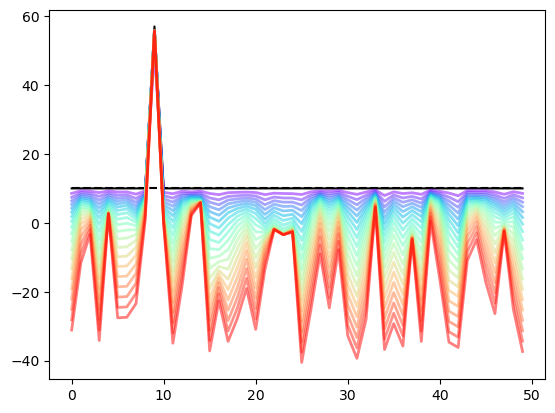

In [9]:
k = 0
dB = True

if dB is True:
    transform = db_transform
else:
    transform = identity

ov2 = -2
res = res_load[ov2]
gamma_init = res_load[ov2]['gamma_init']
gamma_true = res_load[ov2]['gamma_true_full'][nz,:,:]
S_true = transform(gamma_true[:,k,k].real)
S_init = transform(gamma_init[:,k,k].real)

fig, ax = plt.subplots()
ax.plot(S_true, 'k')
ax.plot(S_init, '--', color='k')
plot_spec_em_iters(ax, res['track']['gamma'], k, dB=True)

In [10]:
gamma_true[9,:,:]

Array([[500000.     +0.j, 100000.-100000.j],
       [100000.+100000.j, 500000.     +0.j]], dtype=complex64)

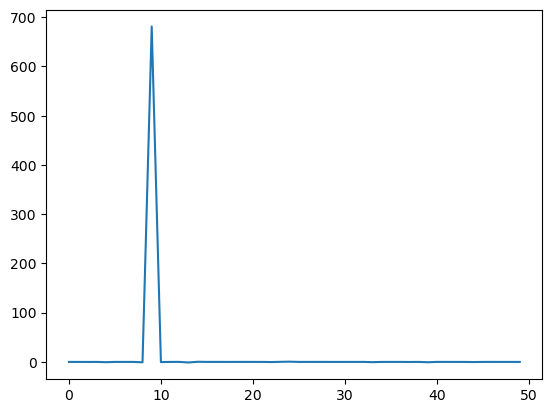

In [11]:
r = 19
k = 0
l = 3
plt.plot(res['track']['mus'][r][:,k,l].real)

In [12]:
cfg = res_load[ov2]['cfg']


lcfg = cfg.latent
ocfg = cfg.obs

L = lcfg.L
ov1 = 1
ov2 = -1
obs_var = ov1 * 10**ov2

lrk = jr.key(lcfg.seed)
ork = jr.key(ocfg.seed)

# nk = 10
# lrk = jr.key(nk)
# ork = jr.key(nk)

zs = sample_from_gamma(lrk, gamma_full, L)
zs_0dc = jnp.apply_along_axis(add0, 0, zs)
xs = jnp.fft.irfft(zs_0dc, axis=0)
obs = xs + jr.normal(ork, xs.shape)*jnp.sqrt(obs_var)

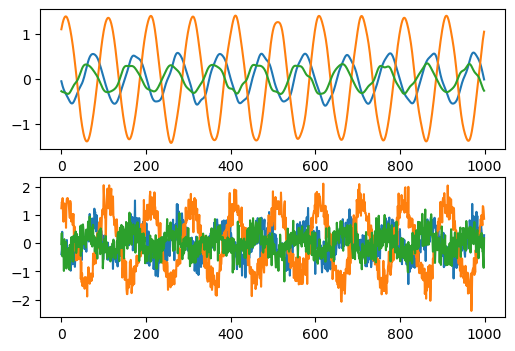

In [13]:
fig, ax = plt.subplots(2,1,figsize=(6,4))
for l in range(3):
    ax[0].plot(xs[:,0,l])
    ax[1].plot(obs[:,0,l])

Next 
- confirm Jax hessian is doing what it should do (recall it produces (n,k,n,k) matrix)
    - confirmed - see `compare_jax_vs_old_check_jhess.ipynb`
- illustrate out what was going wrong (correct the math / computation)
- confirm Old Mod works with scipy optimization 
- move on to point process observations and K > 2 
